In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
torch.manual_seed(42)

## Try Different Shapes of Training Data
#### The General Dataset (World)

In [2]:
# Parameters
device = torch.device("cuda")
batch_size_world = 2048

# create the world dataset
np.random.seed(42)
X_world = np.column_stack((
    np.random.uniform(-4, 6, 55398),
    np.random.uniform(-4, 6, 55398),
    np.random.uniform(0, 3, 55398)
))

angles = np.random.uniform(0, 2 * np.pi, 55398)
Y_world = np.zeros((55398, 3))
for i in range(55398):
    r_world = np.random.uniform(0, 3)
    Y_world[i] = [
        X_world[i, 0] + r_world * np.cos(angles[i]),
        X_world[i, 2] + r_world * np.sin(angles[i]),
        X_world[i, 2] + 10 # assume height of 10
    ]

# Create the Dataloader for the general data
Data_world = np.hstack((Y_world, X_world))
data_world_tensor = torch.tensor(Data_world, dtype=torch.float32).to(device)
dataset_world = TensorDataset(data_world_tensor)
data_world_loader = DataLoader(dataset_world, batch_size=batch_size_world, shuffle=True)

print("Shape for world data: " + str(Data_world.shape))

Shape for world data: (55398, 6)


The specialized dataset (House)

In [3]:
house_num_points = 128
batch_size_house = 64

# Generate the data we want to specialize our model on
np.random.seed(42)
X_house = np.column_stack((
    np.random.uniform(-4, 6, house_num_points),
    np.random.uniform(-4, 6, house_num_points),
    np.random.uniform(0, 3, house_num_points)
))

diviation_number = 0

angles_house = np.random.uniform(0, 2 * np.pi, house_num_points)
Y_house = np.zeros((house_num_points, 3))
for i in range(house_num_points):
    r_house = np.random.uniform(0, 1)
    Y_house[i] = [
        X_house[i, 0] + diviation_number + r_house * np.cos(angles_house[i]),
        X_house[i, 1] + diviation_number + r_house * np.sin(angles_house[i]),
        X_house[i, 2] + 10
    ]

Data_house = np.hstack((Y_house, X_house))
data_house_tensor = torch.tensor(Data_house, dtype=torch.float32).to(device)
dataset_house = TensorDataset(data_house_tensor)
data_house_loader = DataLoader(dataset_house, batch_size=batch_size_house, shuffle=True)

print("Shape for house data: " + str(Data_house.shape))

Shape for house data: (128, 6)


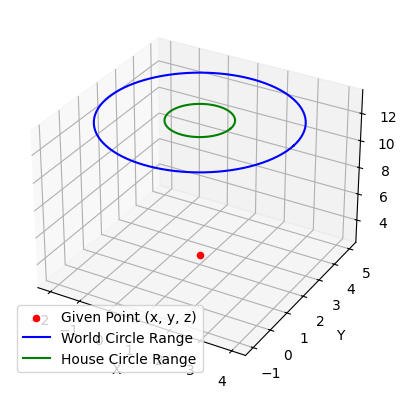

In [4]:
from PIL import Image
# Given point (x, y, z)
x, y, z = 1, 2, 3

# Create figure and 3D axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the point (x, y, z)
ax.scatter(x + diviation_number, y + diviation_number, z, color='red', label='Given Point (x, y, z)')

# Create the first circle with radius 3 centered at (x, y, z + 10)
theta = np.linspace(0, 2 * np.pi, 100)
circle_x1 = 3 * np.cos(theta) + x
circle_y1 = 3 * np.sin(theta) + y
circle_z1 = np.full_like(theta, z + 10)  # z-coordinate is constant for this circle

# Plot the first circle
ax.plot(circle_x1, circle_y1, circle_z1, color='blue', label='World Circle Range')

# Create the second circle with radius 2 centered at (x, y, z)
circle_x2 = 1 * np.cos(theta) + x + diviation_number
circle_y2 = 1 * np.sin(theta) + y + diviation_number
circle_z2 = np.full_like(theta, z + 10)  # z-coordinate is constant for this circle

# Plot the second circle
ax.plot(circle_x2, circle_y2, circle_z2, color='green', label='House Circle Range')

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.savefig("circle_plot.pdf", bbox_inches='tight')  # bbox_inches makes it fit nicely
# Show the plot
plt.show()


## Define the Diffusion Model

In [5]:
# Model Defined
class DiffusionBlock(nn.Module):
    def __init__(self, nunits):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(nunits, nunits)

    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        return x

class DiffusionModel(nn.Module):
    def __init__(self, xfeatures: int, yfeatures: int, nblocks: int = 2, nunits: int = 64):
        super(DiffusionModel, self).__init__()
        self.inblock = nn.Linear(xfeatures + yfeatures + 1, nunits)
        self.midblocks = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.outblock = nn.Linear(nunits, yfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:

        val = torch.hstack([x,  t.type(torch.float32)])
        val = self.inblock(val)
        for midblock in self.midblocks:
            val = midblock(val)
        val = self.outblock(val)
        return val


def noise(Xbatch, t, baralphas, yfeatures):
    # Edited so that it does not give the device error
    Xbatch = Xbatch.to(device)
    Xbatch_temp = Xbatch[:, 0:yfeatures]
    baralphas = baralphas.to(device)
    # noise function
    eps = torch.randn_like(Xbatch_temp)
    noised = (baralphas[t] ** 0.5).view(-1, 1) * Xbatch_temp + ((1 - baralphas[t]) ** 0.5).view(-1, 1) * eps
    noised = torch.hstack([noised, Xbatch[:, yfeatures:]])
    return noised, eps

### Noising Parameters

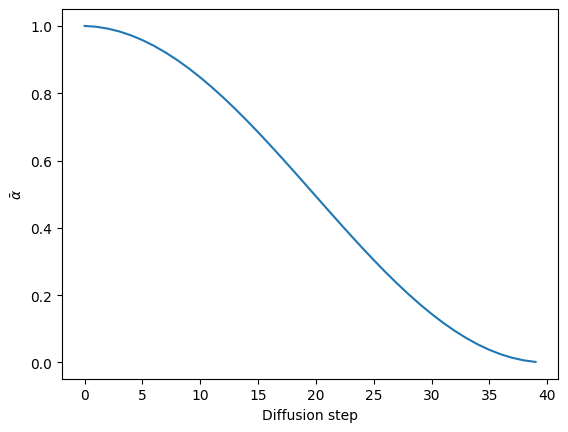

In [6]:
# Define parameters
nepochs = 100

diffusion_steps = 40
s = 0.008
timesteps = torch.tensor(range(0, diffusion_steps), dtype=torch.float32)
schedule = torch.cos((timesteps / diffusion_steps + s) / (1 + s) * np.pi / 2) ** 2

baralphas = schedule / schedule[0]
betas = 1 - baralphas / torch.cat([baralphas[:1], baralphas[:-1]])
alphas = 1 - betas

sns.lineplot(baralphas)
plt.xlabel("Diffusion step")
plt.ylabel(r"$\bar{\alpha}$")
plt.show()

### Training Algorithm

In [7]:
# Initialize
loss_fn = nn.MSELoss()

def train_model(model, data_loader, loss_fn, nepochs, loss_values,
                diffusion_steps, baralphas, device, batch_size, yfeatures):

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

    model.train()

    for epoch in range(nepochs):
        epoch_loss = 0
        for batch in data_loader:
            Xbatch = batch[0].to(device)
            Xbatch = Xbatch.type(torch.float32)

            timesteps = torch.randint(0, diffusion_steps, (len(Xbatch),), dtype=torch.long).to(device)
            noised, eps = noise(Xbatch, timesteps, baralphas, yfeatures)

            predicted_noise = model(noised, timesteps.unsqueeze(-1).type(torch.float32))

            loss = loss_fn(predicted_noise, eps)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(data_loader)
        loss_values.append(avg_loss)

        scheduler.step()  # Update scheduler after each epoch

    return loss_values


### Generate Samples Algorithm

In [8]:
def sample_generate(model, nsamples, X, yfeatures):
    """
    Vectorized sampler for DDPM.

    Args:
        model: The diffusion model.
        nsamples: Number of samples per input coordinate.
        X: Tensor of coordinates, shape (N, 3), where N is the number of coordinate inputs.
        yfeatures: Dimensionality of the target features to sample.

    Returns:
        Y_final: Final denoised outputs, shape (nsamples, N, yfeatures).
        Y_all_steps: List of outputs at each timestep, each of shape (nsamples, N, yfeatures).
    """
    N = X.shape[0]
    device = X.device

    # Expand coordinates: (1, N, 3) -> (nsamples, N, 3) -> (nsamples * N, 3)
    X_coords = X.view(1, N, 3).repeat(nsamples, 1, 1)
    X_coords = X_coords.view(-1, 3)

    # Initial noise sample: (nsamples * N, yfeatures)
    Y = torch.randn(nsamples * N, yfeatures).to(device)

    # Combine with coordinates: (nsamples * N, yfeatures + 3)
    Y_comb = torch.hstack((Y, X_coords))

    Y_all_steps = [Y.view(nsamples, N, yfeatures)]

    with torch.no_grad():
        for t in range(diffusion_steps - 1, 0, -1):
            t_tensor = torch.full((nsamples * N, 1), t, dtype=torch.long, device=device)

            pred_noise = model(Y_comb, t_tensor)

            alpha = alphas[t]
            baralpha = baralphas[t]
            beta = betas[t]

            Y = (1 / alpha**0.5) * (Y - ((1 - alpha) / (1 - baralpha)**0.5) * pred_noise)

            if t > 1:
                noise = torch.randn_like(Y)
                Y += (beta**0.5) * noise

            Y_comb = torch.hstack((Y, X_coords))
            Y_all_steps.append(Y.view(nsamples, N, yfeatures))

    Y_final = Y.view(nsamples, N, yfeatures)
    return Y_final, Y_all_steps


def sample_joint_generate(model1, model2, nsamples, X, yfeatures):
    """
    Vectorized sampler that combines two models in a joint diffusion process.

    Args:
        model1: The first diffusion model.
        model2: The second diffusion model.
        nsamples: Number of samples per coordinate in X.
        X: Tensor of coordinates, shape (N, 3) where N is the number of inputs.
        yfeatures: Dimensionality of the target features to sample.

    Returns:
        Y_final: Final denoised outputs, shape (nsamples, N, yfeatures).
        Y_all_steps: List of outputs at each diffusion timestep, each of shape (nsamples, N, yfeatures).

    Note:
        Assumes that global variables diffusion_steps, alphas, baralphas, and betas are defined.
    """
    N = X.shape[0]
    device = X.device

    # Expand coordinates: (1, N, 3) -> (nsamples, N, 3) -> (nsamples * N, 3)
    X_coords = X.view(1, N, 3).repeat(nsamples, 1, 1).view(-1, 3)

    # Initial noise sample: (nsamples * N, yfeatures)
    Y = torch.randn(nsamples * N, yfeatures).to(device)

    # Combine the noise with the coordinates
    Y_comb = torch.hstack((Y, X_coords))
    Y_all_steps = [Y.view(nsamples, N, yfeatures)]

    with torch.no_grad():
        for t in range(diffusion_steps - 1, 0, -1):
            # Create timestep tensor for all samples
            t_tensor = torch.full((nsamples * N, 1), t, dtype=torch.long, device=device)

            # Get the joint noise prediction from both models
            pred_noise = model1(Y_comb, t_tensor) + model2(Y_comb, t_tensor)

            # Update the sample using the DDPM reverse process update rule
            Y = (1 / (alphas[t] ** 0.5)) * (Y - ((1 - alphas[t]) / ((1 - baralphas[t]) ** 0.5)) * pred_noise)

            # Add noise if not at the last timestep
            if t > 1:
                Y += (betas[t] ** 0.5) * torch.randn_like(Y)

            # Update the combined tensor with the new Y values and constant coordinates
            Y_comb = torch.hstack((Y, X_coords))
            Y_all_steps.append(Y.view(nsamples, N, yfeatures))

    Y_final = Y.view(nsamples, N, yfeatures)
    return Y_final, Y_all_steps

## Training

Training the world model

Model of World Data:
DiffusionModel(
  (inblock): Linear(in_features=7, out_features=64, bias=True)
  (midblocks): ModuleList(
    (0-2): 3 x DiffusionBlock(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (outblock): Linear(in_features=64, out_features=3, bias=True)
)


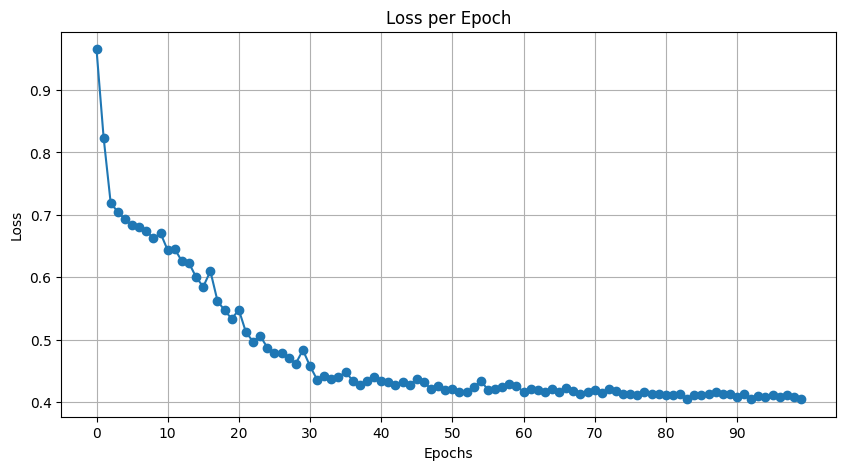

In [9]:
# Define Models
# Model trained only on the world data
model_world = DiffusionModel(xfeatures = 3, yfeatures = 3, nblocks=3)
model_world = model_world.to(device)
print("Model of World Data:")
print(model_world)
epochs = 100

loss_values_world = []
train_model(model_world, data_world_loader, loss_fn, nepochs,
            loss_values_world, diffusion_steps, baralphas, device, batch_size_world, yfeatures=3)
# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(range(0, nepochs), loss_values_world, marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.xticks(ticks=range(0, nepochs, 10))
plt.show()

Training the House model

Model of House Data:
DiffusionModel(
  (inblock): Linear(in_features=7, out_features=64, bias=True)
  (midblocks): ModuleList(
    (0-2): 3 x DiffusionBlock(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (outblock): Linear(in_features=64, out_features=3, bias=True)
)


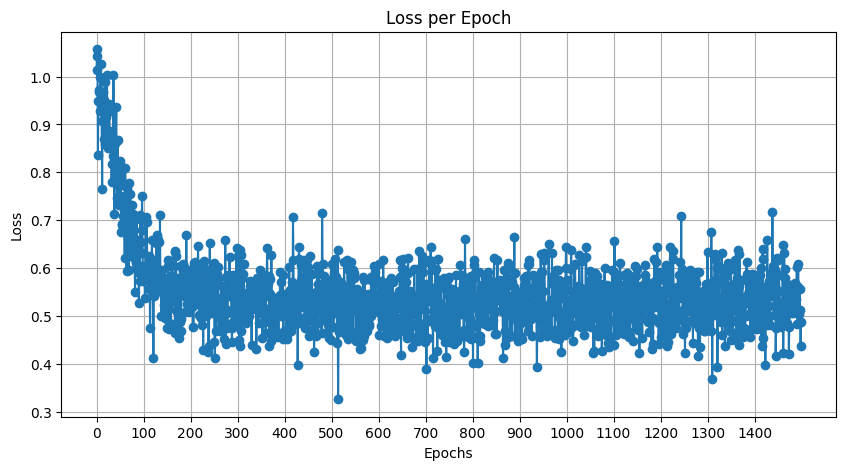

In [10]:
# Model trained only on the house data (This model is expected to be a bad model)
model_house = DiffusionModel(xfeatures = 3, yfeatures = 3, nblocks=3)
model_house = model_house.to(device)
print("Model of House Data:")
print(model_house)
nepochs_house = 1500

loss_values_house = []
train_model(model_house, data_house_loader, loss_fn, nepochs_house,
            loss_values_house, diffusion_steps, baralphas, device, batch_size_house, yfeatures=3)
# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(range(0, nepochs_house), loss_values_house, marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.xticks(ticks=range(0, nepochs_house, 100))
plt.show()

Training the Finetuned Model

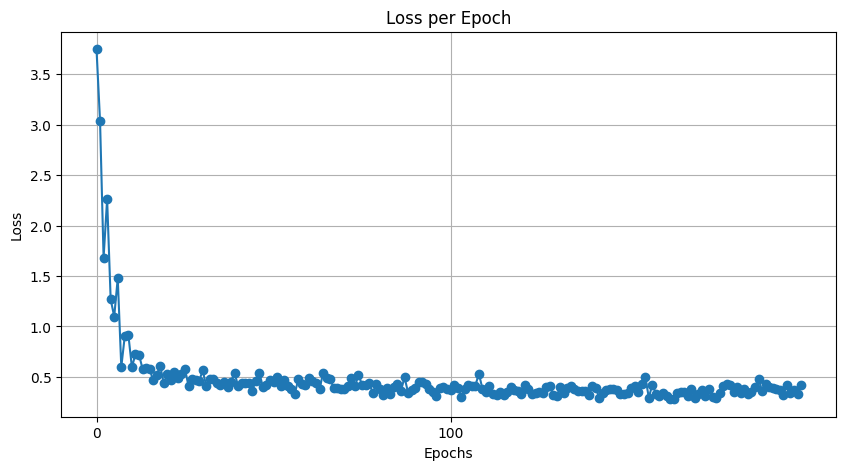

In [12]:
# Create a new model instance
model_finetune = DiffusionModel(xfeatures=3, yfeatures=3, nblocks=3)
model_finetune = model_finetune.to(device)

# Copy the trained weights from model_world
model_finetune.load_state_dict(model_world.state_dict())

# Now, fine-tune model_other on the new dataset
nepochs_finetune = 200
loss_values_finetune = []
train_model(model_finetune, data_house_loader, loss_fn, nepochs_finetune,
            loss_values_finetune, diffusion_steps, baralphas, device, batch_size_house, yfeatures=3)
# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(range(0, nepochs_finetune), loss_values_finetune, marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.xticks(ticks=range(0, nepochs_finetune, 100))
plt.show()

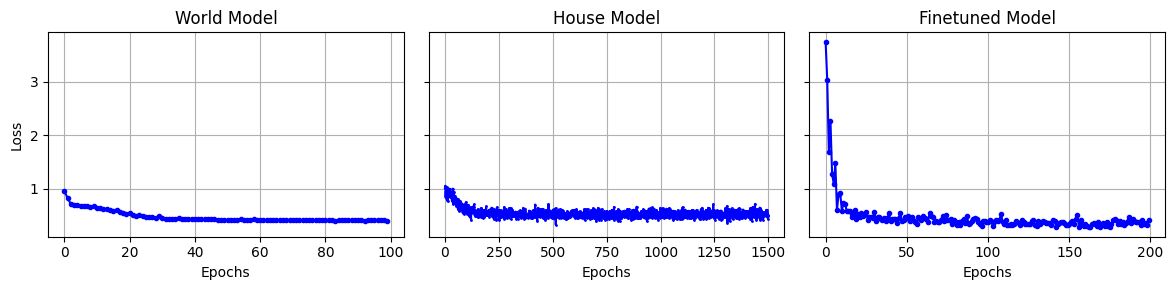

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

# Plot World Model Loss
axes[0].plot(range(0, epochs), loss_values_world, color='blue', marker='o', markersize=3)
axes[0].set_title('World Model')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

# Plot House Model Loss
axes[1].plot(range(0, nepochs_house), loss_values_house, color='blue', marker='o', markersize=1)
axes[1].set_title('House Model')
axes[1].set_xlabel('Epochs')
axes[1].grid(True)

# Plot Joint Model Loss
axes[2].plot(range(0, nepochs_finetune), loss_values_finetune, color='blue', marker='o', markersize=3)
axes[2].set_title('Finetuned Model')
axes[2].set_xlabel('Epochs')
axes[2].grid(True)

# Tight layout to avoid overlap
plt.savefig("training_roundtable.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()

### Testing and Visualization of all the results

Create a test set of fixed ranges

In [ ]:
np.random.seed(40)
num_tests = 100000
test = np.column_stack((
    np.random.uniform(-4, 6, num_tests),
    np.random.uniform(-4, 6, num_tests),
    np.random.uniform(0, 3, num_tests)
))

test = test.astype(np.float32)
print(test.shape)

(100000, 3)


according to the test set, calculate the mean accuracy

In [ ]:
def compute_metrics(samples: np.ndarray, refs: np.ndarray):
    """
    Given:
      - samples: array of shape (S, B, 3)
      - refs:    array of shape (B, 3)

    Returns:
      - acc:     array (B,) of fraction in‑range per ref
      - avg_dist:array (B,) of avg out‑of‑range distance per ref
    """
    S, B, _ = samples.shape

    # split axes
    arr_x = samples[..., 0]
    arr_y = samples[..., 1]
    arr_z = samples[..., 2]

    # refs
    x, y, z = refs[:,0], refs[:,1], refs[:,2]

    # Compute squared distances (to avoid computing sqrt every time)
    dx = arr_x - x[None, :]
    dy = arr_y - y[None, :]
    dist_squared = dx**2 + dy**2  # (S, B)
    # Check Z
    z_low, z_high = z + 9, z + 11
    z_in = (arr_z >= z_low[None, :]) & (arr_z <= z_high[None, :])

    in_range = (dist_squared <= 1) & z_in  # (S, B)

    # accuracy per ref
    acc = in_range.mean(axis=0)   # (B,)

    # distances
    dz = np.abs(arr_z - z)
    dist = np.sqrt(dist_squared + dz*dz)  # (S,B)

    # sum & count of out‑of‑range
    mask_out   = ~in_range
    sum_out    = (dist * mask_out).sum(axis=0)   # (B,)
    count_out  = mask_out.sum(axis=0)            # (B,)

    # safe division: only divide where count_out>0
    avg_dist = np.zeros_like(sum_out, dtype=float)
    np.divide(sum_out, count_out, out=avg_dist, where=count_out>0)

    return acc, avg_dist


def accuracy_distance_report(testset, nsamples):
    """
    Fully vectorized: no Python loops over points or coords.
    """
    # B reference coords
    refs = np.asarray(testset, dtype=np.float32)    # shape (B,3)
    B = refs.shape[0]

    coords_t = torch.tensor(refs, device=device)     # (B,3)

    # 1) World model
    samples_w, _ = sample_generate(model_world,
                                   nsamples=nsamples,
                                   X=coords_t,
                                   yfeatures=3)    # (S,B,3)
    arr_w = samples_w.cpu().numpy()
    acc_w, dist_w = compute_metrics(arr_w, refs)

    # 2) House model
    samples_h, _ = sample_generate(model_house, nsamples=nsamples,
                                   X=coords_t, yfeatures=3)
    arr_h = samples_h.cpu().numpy()
    acc_h, dist_h = compute_metrics(arr_h, refs)

    # 3) Finetuned model
    samples_f, _ = sample_generate(model_finetune, nsamples=nsamples,
                                   X=coords_t, yfeatures=3)
    arr_f = samples_f.cpu().numpy()
    acc_f, dist_f = compute_metrics(arr_f, refs)

    # 4) Joint1 (house + world)
    samples_j1, _ = sample_joint_generate(model_house, model_world,
                                          nsamples=nsamples,
                                          X=coords_t, yfeatures=3)
    arr_j1 = samples_j1.cpu().numpy()
    acc_j1, dist_j1 = compute_metrics(arr_j1, refs)

    # 5) Joint2 (finetune + world)
    samples_j2, _ = sample_joint_generate(model_finetune, model_world,
                                          nsamples=nsamples,
                                          X=coords_t, yfeatures=3)
    arr_j2 = samples_j2.cpu().numpy()
    acc_j2, dist_j2 = compute_metrics(arr_j2, refs)

    # Finally: mean across the B test points
    return (
        acc_w.mean(), acc_h.mean(), acc_j1.mean(), acc_f.mean(), acc_j2.mean(),
        dist_w.mean(), dist_h.mean(), dist_j1.mean(), dist_f.mean(), dist_j2.mean()
    )

calculate the distance of points out of range

In [ ]:
# Example usage:
(acc_world_final, acc_house_final, acc_joint_final, acc_finetune_final, acc_joint2_final,
 avg_dist_world, avg_dist_house, avg_dist_joint, avg_dist_finetune, avg_dist_joint2) = accuracy_distance_report(test, nsamples = 10)

print("World Accuracy: ", acc_world_final)
print("House Accuracy: ", acc_house_final)
print("Joint Accuracy: ", acc_joint_final)
print("Finetuned Accuracy: ", acc_finetune_final)
print("Joint2 Accuracy: ", acc_joint2_final)

print("World Avg. Out-of-Range Distance: ", avg_dist_world)
print("House Avg. Out-of-Range Distance: ", avg_dist_house)
print("Joint Avg. Out-of-Range Distance: ", avg_dist_joint)
print("Finetuned Avg. Out-of-Range Distance: ", avg_dist_finetune)
print("Joint2 Avg. Out-of-Range Distance: ", avg_dist_joint2)

World Accuracy:  0.09070500000000002
House Accuracy:  0.03822400000000001
Joint Accuracy:  0.6649909999999999
Finetuned Accuracy:  0.36305800000000005
Joint2 Accuracy:  0.24848300000000004
World Avg. Out-of-Range Distance:  10.608625366558316
House Avg. Out-of-Range Distance:  17.76650709268659
Joint Avg. Out-of-Range Distance:  8.043686464827825
Finetuned Avg. Out-of-Range Distance:  10.210514829673919
Joint2 Avg. Out-of-Range Distance:  10.228364036849188


plot one data point and its generated samples as a reference

### plotting

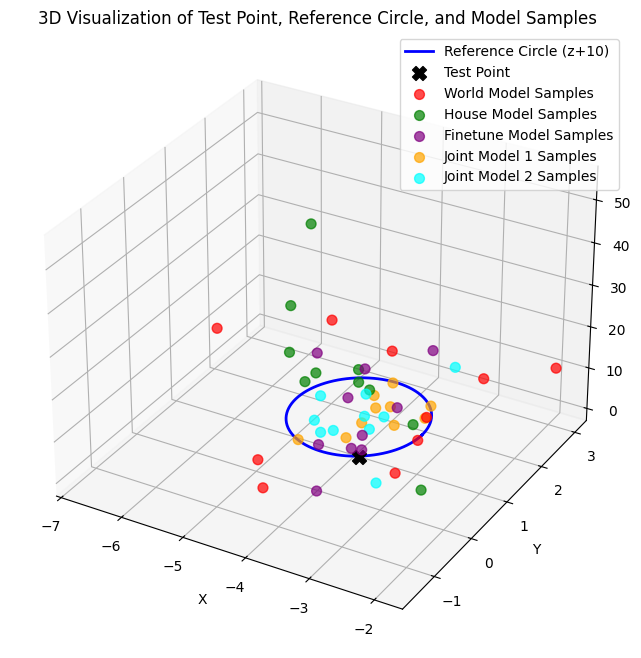

In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# Ensure inline plotting for Jupyter
%matplotlib inline

# Select a test point
test_point = test[14]
x, y, z = test_point
test_point = torch.tensor(test_point, device=device).view(1, 3, 1)

# generate samples
# World Model
final_samples_world, all_samples_world = sample_generate(model_world, nsamples=10, X=test_point, yfeatures=3)

# House Model
final_samples_house, all_samples_house = sample_generate(model_house, nsamples=10, X=test_point, yfeatures=3)

# Finetune Model
final_samples_finetune, all_samples_finetune = sample_generate(model_finetune, nsamples=10, X=test_point, yfeatures=3)

# Joint Model 1
final_samples_joint, all_samples_joint = sample_joint_generate(model_house, model_world, nsamples=10, X=test_point, yfeatures=3)

# Joint Model 2
final_samples_joint2, all_samples_joint2 = sample_joint_generate(model_finetune, model_world, nsamples=10, X=test_point, yfeatures=3)

# Convert tensors to NumPy (Ensure tensors are moved to CPU first)
def to_numpy(tensor):
    return tensor.cpu().numpy() if isinstance(tensor, torch.Tensor) else np.array(tensor)

final_samples_world = to_numpy(final_samples_world).reshape(-1, 3)
final_samples_house = to_numpy(final_samples_house).reshape(-1, 3)
final_samples_finetune = to_numpy(final_samples_finetune).reshape(-1, 3)
final_samples_joint = to_numpy(final_samples_joint).reshape(-1, 3)
final_samples_joint2 = to_numpy(final_samples_joint2).reshape(-1, 3)

# Circle parameters
radius = 1
center = np.array([x, y, z + 10])
num_points = 100

# Generate circle points at z = z + 10
angles = np.linspace(0, 2 * np.pi, num_points)
circle_x = center[0] + radius * np.cos(angles)
circle_y = center[1] + radius * np.sin(angles)
circle_z = np.full_like(angles, center[2])

# Create figure and 3D axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the reference circle at z = z+10
ax.plot(circle_x, circle_y, circle_z, label='Reference Circle (z+10)', color='blue', linewidth=2)

# Plot the test point
ax.scatter(x, y, z, color='black', label='Test Point', s=100, marker='X')

# Plot model-generated samples
ax.scatter(final_samples_world[:, 0], final_samples_world[:, 1], final_samples_world[:, 2],
           color='red', label='World Model Samples', s=50, alpha=0.7)
ax.scatter(final_samples_house[:, 0], final_samples_house[:, 1], final_samples_house[:, 2],
           color='green', label='House Model Samples', s=50, alpha=0.7)
ax.scatter(final_samples_finetune[:, 0], final_samples_finetune[:, 1], final_samples_finetune[:, 2],
           color='purple', label='Finetune Model Samples', s=50, alpha=0.7)
ax.scatter(final_samples_joint[:, 0], final_samples_joint[:, 1], final_samples_joint[:, 2],
           color='orange', label='Joint Model 1 Samples', s=50, alpha=0.7)
ax.scatter(final_samples_joint2[:, 0], final_samples_joint2[:, 1], final_samples_joint2[:, 2],
           color='cyan', label='Joint Model 2 Samples', s=50, alpha=0.7)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Visualization of Test Point, Reference Circle, and Model Samples')

# Add legend and display
ax.legend()
plt.show()


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()